In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
import zipfile, os
from huggingface_hub import hf_hub_download
import glob
from tqdm.autonotebook import tqdm
import cv2
import csv
import numpy as np
from collections import defaultdict

In [ ]:
# load data from hugging face and unzip
zip_path  = hf_hub_download(repo_id="bryanbocao/coco_minitrain",filename = "coco_minitrain_25k.zip",repo_type="dataset")
output_dir = "coco_minitrain_25k"
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
  z.extractall('')
  z.close()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


coco_minitrain_25k.zip:   0%|          | 0.00/11.5G [00:00<?, ?B/s]

In [ ]:
#read jason file
import json

json_path = os.path.join(output_dir, "person_keypoints_minitrain2017.json")

with open(json_path, 'r') as f:
    data = json.load(f)

# Check top-level keys
print("Top-level keys in JSON:", data.keys())


Top-level keys in JSON: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [ ]:
# Map image_id -> list of annotations
image_to_annots = defaultdict(list)
for ann in data['annotations']:
    image_to_annots[ann['image_id']].append(ann)

# Map image_id -> file_name
id_to_file = {img['id']: img['file_name'] for img in data['images']}

In [ ]:
# Check first image entry
print(data['images'][0])

# Check first annotation
print(data['annotations'][0])


{'license': 2, 'file_name': '000000490242.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000490242.jpg', 'height': 640, 'width': 427, 'date_captured': '2013-11-20 04:49:09', 'flickr_url': 'http://farm3.staticflickr.com/2736/4307613044_9b866854ed_z.jpg', 'id': 490242}
{'segmentation': [[181.83, 593.02, 213.33, 603.04, 210.47, 640, 103.09, 640, 104.52, 590.16, 88.77, 562.95, 93.06, 501.39, 93.06, 452.71, 84.47, 411.19, 74.45, 363.94, 51.54, 272.3, 37.23, 193.56, 58.7, 156.33, 83.04, 142.01, 77.32, 117.67, 87.34, 94.77, 85.91, 100.49, 103.09, 41.79, 137.45, 36.06, 170.38, 73.29, 168.95, 106.22, 166.09, 134.85, 161.79, 146.31, 144.61, 162.06, 191.86, 215.03, 239.11, 227.92, 257.72, 219.33, 279.19, 219.33, 280.63, 242.24, 262.01, 250.83, 253.42, 246.53, 230.51, 257.99, 194.72, 262.28, 190.43, 286.62, 200.45, 298.08, 186.13, 329.57, 206.17, 336.73, 220.49, 361.07, 201.88, 378.26, 178.97, 372.53, 174.68, 404.03, 180.4, 508.55, 170.38, 545.77, 188.99, 554.36, 183.27, 565.82, 166

In [ ]:
# check key point in jason file
kpts = data['annotations'][0]['keypoints']
print("Number of keypoints:", len(kpts)//3)

Number of keypoints: 17


In [3]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# write ymal file for training model

# Path to your dataset
dataset_path = "/content"

# YAML content
yaml_content = f"""
train: /content/coco_minitrain_25k/images/train2017
val:  /content/coco_minitrain_25k/images/val2017

nc: 1               # number of classes
names: ['person']   # class names

keypoints:
  train: /content/coco_minitrain_25k/person_keypoints_minitrain2017.json
  val: /content/coco_minitrain_25k/person_keypoints_minitrain2017.json

kpt_shape: [17, 3] # number of keypoints, number of dims (2 for x,y or 3 for x,y,visible)
flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
kpt_names:
  0:
    - nose
    - left_eye
    - right_eye
    - left_ear
    - right_ear
    - left_shoulder
    - right_shoulder
    - left_elbow
    - right_elbow
    - left_wrist
    - right_wrist
    - left_hip
    - right_hip
    - left_knee
    - right_knee
    - left_ankle
    - right_ankle
"""

# Save YAML file
yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("data.yaml created at:", yaml_path)


data.yaml created at: /content/data.yaml


In [ ]:
# delete file in label folder train


for filename in os.listdir('/content/coco_minitrain_25k/labels/train2017'):
    file_path = os.path.join('/content/coco_minitrain_25k/labels/train2017', filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)      # delete file
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # delete subfolder
    except Exception as e:
        print(f"Failed to delete {file_path}: {e}")

In [ ]:
# delete file in label folder val

import shutil
for filename in os.listdir('/content/coco_minitrain_25k/labels/val2017'):
    file_path = os.path.join('/content/coco_minitrain_25k/labels/val2017', filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)      # delete file
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # delete subfolder
    except Exception as e:
        print(f"Failed to delete {file_path}: {e}")

In [ ]:
# write label format for train

image_info = {img['id']: img for img in data['images']}
labels_dir = '/content/coco_minitrain_25k/labels/train2017'
os.makedirs(labels_dir, exist_ok=True)
for ann in tqdm(data["annotations"]):
    if ann["num_keypoints"] == 0:
        continue

    img = image_info[ann["image_id"]]
    img_w, img_h = img["width"], img["height"]

    # Convert COCO bbox → YOLO bbox
    x, y, w, h = ann["bbox"]
    x_center = (x + w/2) / img_w
    y_center = (y + h/2) / img_h
    w /= img_w
    h /= img_h

    # Keypoints (COCO format is already absolute)
    kps = ann["keypoints"]
    kps_norm = []
    for i in range(0, len(kps), 3):
        kps_norm.append(kps[i]   / img_w)   # x
        kps_norm.append(kps[i+1] / img_h)   # y
        kps_norm.append(kps[i+2])           # v

    # Build label line
    label_line = "0 " + f"{x_center} {y_center} {w} {h} " + " ".join(map(str, kps_norm)) + "\n"

    # Filename
    label_filename = os.path.splitext(img["file_name"])[0] + ".txt"
    label_path = os.path.join(labels_dir, label_filename)

    # Write (append for multiple persons)
    with open(label_path, "a") as f:
        f.write(label_line)

  0%|          | 0/60993 [00:00<?, ?it/s]

In [ ]:
# write label format for label

image_info = {img['id']: img for img in data['images']}
labels_dir = '/content/coco_minitrain_25k/labels/val2017'
os.makedirs(labels_dir, exist_ok=True)
for ann in tqdm(data["annotations"]):
    if ann["num_keypoints"] == 0:
        continue

    img = image_info[ann["image_id"]]
    img_w, img_h = img["width"], img["height"]

    # Convert COCO bbox → YOLO bbox
    x, y, w, h = ann["bbox"]
    x_center = (x + w/2) / img_w
    y_center = (y + h/2) / img_h
    w /= img_w
    h /= img_h

    # Keypoints (COCO format is already absolute)
    kps = ann["keypoints"]
    kps_norm = []
    for i in range(0, len(kps), 3):
        kps_norm.append(kps[i]   / img_w)   # x
        kps_norm.append(kps[i+1] / img_h)   # y
        kps_norm.append(kps[i+2])           # v

    # Build label line
    label_line = "0 " + f"{x_center} {y_center} {w} {h} " + " ".join(map(str, kps_norm)) + "\n"

    # Filename
    label_filename = os.path.splitext(img["file_name"])[0] + ".txt"
    label_path = os.path.join(labels_dir, label_filename)

    # Write (append for multiple persons)
    with open(label_path, "a") as f:
        f.write(label_line)

  0%|          | 0/60993 [00:00<?, ?it/s]

In [ ]:
# count the number of files

label_folder = os.path.join(output_dir, "labels/train2017")
label = os.listdir(image_folder)
print(f"Total images found: {len(label)}")

Total images found: 25000
First 5 images: ['000000246549.jpg', '000000054178.jpg', '000000373895.jpg', '000000083736.jpg', '000000208163.jpg']


In [ ]:
# count the number of files

label_folder = os.path.join(output_dir, "labels/val2017")
label = os.listdir(image_folder)
print(f"Total images found: {len(label)}")

Total images found: 25000
First 5 images: ['000000246549.jpg', '000000054178.jpg', '000000373895.jpg', '000000083736.jpg', '000000208163.jpg']


In [ ]:
# remove image that have on label and lable that have on image in train folder

image_files = set(os.listdir("/content/coco_minitrain_25k/images/train2017"))
label_files = set(os.listdir("/content/coco_minitrain_25k/labels/train2017"))

# Remove images without labels
for img in image_files:
    lbl_name = img.replace(".jpg", ".txt")
    if lbl_name not in label_files:
        os.remove(os.path.join("/content/coco_minitrain_25k/images/train2017", img))

# Remove labels without images
for lbl in label_files:
    img_name = lbl.replace(".txt", ".jpg")
    if img_name not in image_files:
        os.remove(os.path.join("/content/coco_minitrain_25k/labels/train2017", lbl))

In [ ]:
# remove image that have on label and lable that have on image in val folder

image_files = set(os.listdir("/content/coco_minitrain_25k/images/val2017"))
label_files = set(os.listdir("/content/coco_minitrain_25k/labels/val2017"))

# Remove images without labels
for img in image_files:
    lbl_name = img.replace(".jpg", ".txt")
    if lbl_name not in label_files:
        os.remove(os.path.join("/content/coco_minitrain_25k/images/val2017", img))

# Remove labels without images
for lbl in label_files:
    img_name = lbl.replace(".txt", ".jpg")
    if img_name not in image_files:
        os.remove(os.path.join("/content/coco_minitrain_25k/labels/val2017", lbl))

In [ ]:

# for lbl in os.listdir("/content/coco_minitrain_25k/labels/train2017"):
#     with open(os.path.join("/content/coco_minitrain_25k/labels/train2017", lbl)) as f:
#         lines = f.readlines()
#         if len(lines) == 0:
#             os.remove(os.path.join("/content/coco_minitrain_25k/labels/train2017", lbl))
#             os.remove(os.path.join("/content/coco_minitrain_25k/images/train2017", lbl.replace(".txt",".jpg")))

In [ ]:
#check img
train_count = len(os.listdir("/content/coco_minitrain_25k/labels/train2017"))
val_count = len(os.listdir("/content/coco_minitrain_25k/labels/val2017"))

print("Train images:", train_count)
print("Val images:", val_count)

Train images: 2814
Val images: 0


In [ ]:
#check label
train_count = len(os.listdir("/content/coco_minitrain_25k/labels/train2017"))
val_count = len(os.listdir("/content/coco_minitrain_25k/labels/val2017"))

print("Train images:", train_count)
print("Val images:", val_count)

Train images: 2814
Val images: 0


In [ ]:
#split train (plase rename train2017 to train2017old in both image and label)
import random
# Set paths
image_dir = "/content/coco_minitrain_25k/images/train2017old"
label_dir = "/content/coco_minitrain_25k/labels/train2017old"

train_img_dir = "/content/coco_minitrain_25k/images/train2017"
val_img_dir   = "/content/coco_minitrain_25k/images/val2017"
train_lbl_dir = "/content/coco_minitrain_25k/labels/train2017"
val_lbl_dir   = "/content/coco_minitrain_25k/labels/val2017"

# Create folders
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# List all images
images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Split percentage
val_ratio = 0.2  # 20% validation
random.shuffle(images)

val_count = int(len(images) * val_ratio)
val_images = images[:val_count]
train_images = images[val_count:]

# Move files
for img in train_images:
    label = img.rsplit('.', 1)[0] + ".txt"
    shutil.move(os.path.join(image_dir, img), os.path.join(train_img_dir, img))
    shutil.move(os.path.join(label_dir, label), os.path.join(train_lbl_dir, label))

for img in val_images:
    label = img.rsplit('.', 1)[0] + ".txt"
    shutil.move(os.path.join(image_dir, img), os.path.join(val_img_dir, img))
    shutil.move(os.path.join(label_dir, label), os.path.join(val_lbl_dir, label))


In [ ]:
#check label
train_count = len(os.listdir("/content/coco_minitrain_25k/labels/train2017"))
val_count = len(os.listdir("/content/coco_minitrain_25k/labels/val2017"))

print("Train images:", train_count)
print("Val images:", val_count)

Train images: 2252
Val images: 562


In [ ]:
# Load pretrained YOLOv8-Pose nano model
model = YOLO("yolo11n-pose.pt")

# Train the model
model.train(
    data='/content/data.yaml',    # path to data.yaml
    epochs=10,         # number of training epochs
    imgsz=640,         # input image size
    batch=16,          # batch size
)

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0cf8e6dc70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034, 

In [ ]:
# # test model
# results = model("https://ultralytics.com/images/bus.jpg")

# for result in results:
#     result.show()


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 4 persons, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


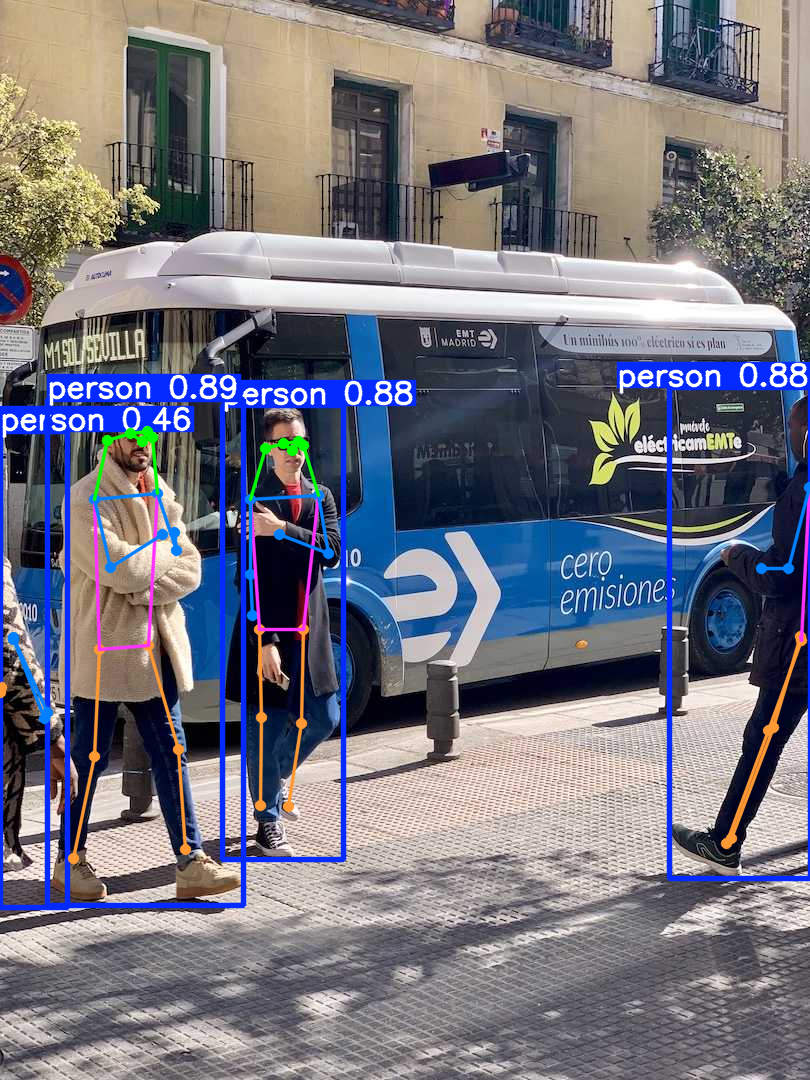

0.8870384097099304
0.8809612393379211
0.8779017925262451
0.45770832896232605


In [ ]:
# test model
defultmodel = YOLO("yolo11n-pose.pt")

result = defultmodel("https://ultralytics.com/images/bus.jpg")

for result in result:
    result.show()
    for box in result.boxes:
      print(float(box.conf))


In [ ]:
# test model
bestmodel = YOLO("/content/best.pt")

best = bestmodel("https://ultralytics.com/images/bus.jpg")

for best in best:
    best.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/best.pt'

In [43]:
def import_meme2skel():
    Model = YOLO("/content/best.pt")
    array_for_test = []

    for i in range(10):
        results = Model(f"/content/sample_data/meme4test/meme{i+1}.jpg")
        img_keypoints = []
        for r in results:
            #r.show()

            boxes = r.boxes
            keypoints = r.keypoints.xy  # shape: (N, 17, 2)

            for idx in range(len(boxes)):
                box = boxes[idx]

                if float(box.conf) < 0.5:
                    continue

                kpt = keypoints[idx]  # keypoints ของคน idx

                person_kpts = []
                for (x, y) in kpt:
                    person_kpts.append([float(x), float(y)])
                img_keypoints.append(person_kpts)

        array_for_test.append(img_keypoints)

    return array_for_test


In [44]:
def pose_distance_norm(kpt1, kpt2):
    # ถ้าจำนวนจุดไม่เท่ากัน ไม่คำนวณ
    if len(kpt1) != len(kpt2):
        return float("inf")

    k1 = normalize_keypoints(kpt1)
    k2 = normalize_keypoints(kpt2)

    return np.mean(np.linalg.norm(k1 - k2, axis=1))

In [45]:
def pad_keypoints(kpts, target_len):
    kpts = list(kpts)
    while len(kpts) < target_len:
        kpts.append([0.0, 0.0])
    return np.array(kpts)


image 1/1 /content/sample_data/meme4test/meme1.jpg: 352x640 1 person, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /content/sample_data/meme4test/meme2.jpg: 640x544 1 person, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/sample_data/meme4test/meme3.jpg: 480x640 1 person, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/sample_data/meme4test/meme4.jpg: 384x640 1 person, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/sample_data/meme4test/meme5.jpg: 544x640 1 person, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/sample_data/meme4test/meme6.jpg: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.5ms postproc

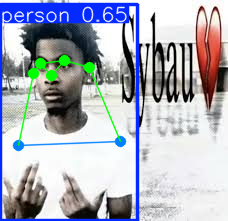

===== TOP 3 RESULTS =====
[#1] Meme 6, Meme Person 0, Test Person 0, Score = 0.0
[#2] Meme 7, Meme Person 0, Test Person 0, Score = 0.13435208228025775
[#3] Meme 8, Meme Person 0, Test Person 0, Score = 0.13699664337112205


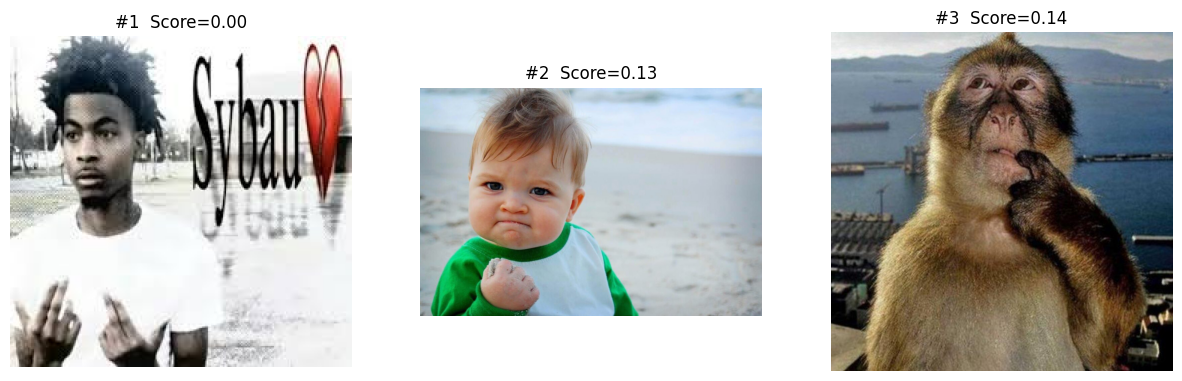

In [58]:
meme_array = import_meme2skel()
image_input_array = import_pic2skel()
meme_paths = [
    "/content/sample_data/meme4test/meme1.jpg",
    "/content/sample_data/meme4test/meme2.jpg",
    "/content/sample_data/meme4test/meme3.jpg",
    "/content/sample_data/meme4test/meme4.jpg",
    "/content/sample_data/meme4test/meme5.jpg",
    "/content/sample_data/meme4test/meme6.jpg",
    "/content/sample_data/meme4test/meme7.jpg",
    "/content/sample_data/meme4test/meme8.jpg",
    "/content/sample_data/meme4test/meme9.jpg",
    "/content/sample_data/meme4test/meme10.jpg"
]
name = compare_meme_system(meme_array,image_input_array,meme_paths)

In [57]:
def import_pic2skel():
    Model = YOLO("/content/best.pt")
    array_for_test = []

    results = Model("/content/sample_data/meme4test/meme6.jpg")

    img_keypoints = []

    for r in results:
        r.show()

        boxes = r.boxes
        keypoints = r.keypoints.xy  # shape: (num_person, 17, 2)

        for i in range(len(boxes)):
            box = boxes[i]

            if float(box.conf) < 0.5:
                continue

            kpt = keypoints[i]

            person_kpts = []
            for (x, y) in kpt:
                person_kpts.append([float(x), float(y)])

            img_keypoints.append(person_kpts)

    array_for_test.append(img_keypoints)
    return array_for_test

In [47]:
def normalize_keypoints(kpts):
    kpts = np.array(kpts)
    min_xy = kpts.min(axis=0)
    max_xy = kpts.max(axis=0)

    return (kpts - min_xy) / (max_xy - min_xy + 1e-6)

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def compare_meme_system(meme_array, image_input_array, meme_paths):

    test_people = image_input_array[0]   # list คนในภาพ test

    results = []   # เก็บผลทุกอัน (score, meme_idx, meme_person, test_person)

    # เก็บค่า score ทั้งหมด
    for test_idx, test_kpt in enumerate(test_people):
        for meme_idx, meme_img in enumerate(meme_array):
          count=0
          for meme_person_idx, meme_kpt in enumerate(meme_img):
              count +=1
              score = pose_distance_norm(test_kpt, meme_kpt)
              if(count > 9):
                continue
              results.append({
                    "score": score,
                    "meme": meme_idx,
                    "meme_person": meme_person_idx,
                    "test_person": test_idx
                })

    # เรียงจาก score น้อย → มาก
    results = sorted(results, key=lambda x: x["score"])

    # เอา Top 3
    top3 = results[:3]

    print("===== TOP 3 RESULTS =====")
    for rank, r in enumerate(top3, start=1):
        print(f"[#{rank}] Meme {r['meme']+1}, Meme Person {r['meme_person']}, Test Person {r['test_person']}, Score = {r['score']}")

    # ---------------------------
    # แสดงรูป 3 อันดับบนแยกเป็นรูป ๆ
    # ---------------------------
    plt.figure(figsize=(15,5))

    for i, r in enumerate(top3):
        meme_img_path = meme_paths[r["meme"]]
        img = cv2.imread(meme_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.title(f"#{i+1}  Score={r['score']:.2f}")
        plt.axis('off')

    plt.show()






image 1/1 /content/sample_data/meme4test/meme1.jpg: 352x640 1 person, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /content/sample_data/meme4test/meme2.jpg: 640x544 1 person, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/sample_data/meme4test/meme3.jpg: 480x640 1 person, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/sample_data/meme4test/meme4.jpg: 384x640 1 person, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/sample_data/meme4test/meme5.jpg: 544x640 1 person, 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/sample_data/meme4test/meme6.jpg: 640x640 1 person, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.6ms postproc

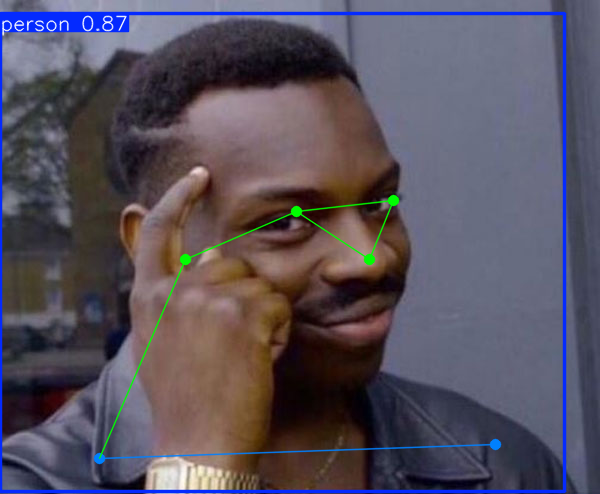

===== TOP 3 RESULTS =====
[#1] Meme 5, Meme Person 0, Test Person 0, Score = 0.0
[#2] Meme 8, Meme Person 0, Test Person 0, Score = 0.1396257073662215
[#3] Meme 7, Meme Person 0, Test Person 0, Score = 0.15534352890919131


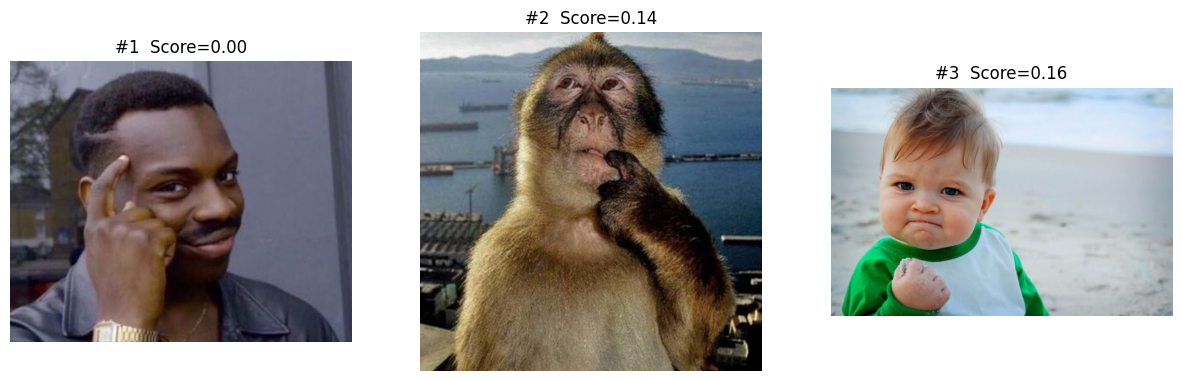

In [31]:
meme_array = import_meme2skel()
image_input_array = import_pic2skel()
meme_paths = [
    "/content/sample_data/meme4test/meme1.jpg",
    "/content/sample_data/meme4test/meme2.jpg",
    "/content/sample_data/meme4test/meme3.jpg",
    "/content/sample_data/meme4test/meme4.jpg",
    "/content/sample_data/meme4test/meme5.jpg",
    "/content/sample_data/meme4test/meme6.jpg",
    "/content/sample_data/meme4test/meme7.jpg",
    "/content/sample_data/meme4test/meme8.jpg",
    "/content/sample_data/meme4test/meme9.jpg",
    "/content/sample_data/meme4test/meme10.jpg"
]
name = compare_meme_system(meme_array,image_input_array,meme_paths)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.7 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 22 packages in 2s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇

2025-11-24 14:55:16.861 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-24 14:55:17.220 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-24 14:55:17.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-24 14:55:17.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-24 14:55:17.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-24 14:55:17.230 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-24 14:55:17.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


ERROR:pyngrok.process.ngrok:t=2025-11-24T14:56:16+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: YOUR_NGROK_AUTH_TOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-11-24T14:56:16+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: YOUR_NGROK_AUTH_TOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: YOUR_NGROK_AUTH_TOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.